# Compress_attn

In [1]:
import torch
import triton
import math
from copy import deepcopy
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
from torch_code import torch_blcok_compress, torch_cmp_attn, flex_cmp_attn
from compress_attn import blcok_compress as triton_block_compress
from compress_attn import compress_attn as triton_compress_attn

## block_compress
- 目前这个版本weight是[kernel_size], pe是[kernel_size, v_head_dim / k_head_dim]

### 精度

In [ ]:
device = 'cuda'
dtype = torch.bfloat16
# 论文中k的配置
b, h, n, d = 1, 4, 4096, 192
stride = 16
kernel_size = 32
x1 = torch.randn(b, n, h, d, device=device, dtype=dtype)
x1.requires_grad_(True)
weight1 = torch.nn.Parameter(torch.randn(kernel_size, device=device, dtype=dtype))
pe1 = torch.nn.Parameter(torch.randn(kernel_size, d, device=device, dtype=dtype))
x2 = deepcopy(x1)
weight2 = deepcopy(weight1)
pe2 = deepcopy(pe1)
x3 = torch.randn(b, n, h, d, device=device, dtype=torch.float32)
x3.requires_grad_(True)
weight3 = torch.nn.Parameter(torch.randn(kernel_size, device=device, dtype=torch.float32))
pe3 = torch.nn.Parameter(torch.randn(kernel_size, d, device=device, dtype=torch.float32))
x3.data.copy_(x1.data)
weight3.data.copy_(weight1.data)
pe3.data.copy_(pe1.data)

y1 = torch_blcok_compress(x1, weight1, pe1, stride)
y2 = triton_block_compress(x2, weight2, pe2, stride)
y3 = torch_blcok_compress(x3, weight3, pe3, stride)
dy = torch.rand_like(y1)
y1.backward(dy)
y2.backward(dy)
y3.backward(dy.float())
print('='*50 + ' forward output:')
print(f'torch   bf16 vs torch fp32: 最大差值: {(y1-y3).abs().max().item()}, 平均差值: {(y1-y3).abs().mean().item()}')
print(f'triton  bf16 vs torch fp32: 最大差值: {(y2-y3).abs().max().item()}, 平均差值: {(y2-y3).abs().mean().item()}')
print('='*50 + ' backward input grad:')
print(f'torch   bf16 vs torch fp32: 最大差值: {(x1.grad-x3.grad).abs().max().item()}, 平均差值: {(x1.grad-x3.grad).abs().mean().item()}')
print(f'triton  bf16 vs torch fp32: 最大差值: {(x2.grad-x3.grad).abs().max().item()}, 平均差值: {(x2.grad-x3.grad).abs().mean().item()}')
print('='*50 + ' backward weight grad:')
print(f'torch   bf16 vs torch fp32: 最大差值: {(weight1.grad-weight3.grad).abs().max().item()}, 平均差值: {(weight1.grad-weight3.grad).abs().mean().item()}')
print(f'triton  bf16 vs torch fp32: 最大差值: {(weight2.grad-weight3.grad).abs().max().item()}, 平均差值: {(weight2.grad-weight3.grad).abs().mean().item()}')
print('='*50 + ' backward pe grad:')
print(f'torch   bf16 vs torch fp32: 最大差值: {(pe1.grad-pe3.grad).abs().max().item()}, 平均差值: {(pe1.grad-pe3.grad).abs().mean().item()}')
print(f'triton  bf16 vs torch fp32: 最大差值: {(pe2.grad-pe3.grad).abs().max().item()}, 平均差值: {(pe2.grad-pe3.grad).abs().mean().item()}')

### forward

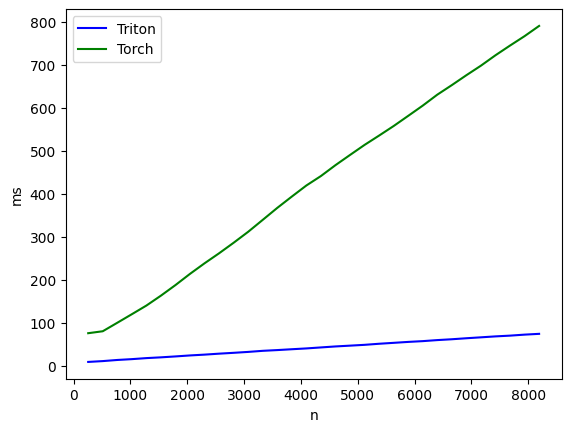

forward:
         n     Triton       Torch
0    256.0   9.164627   75.977601
1    512.0  11.082030   80.510318
2    768.0  13.706696  100.258015
3   1024.0  15.640816  120.139457
4   1280.0  18.035911  140.256345
5   1536.0  19.822905  163.343757
6   1792.0  21.949554  187.950209
7   2048.0  24.251208  214.052320
8   2304.0  26.137266  238.618627
9   2560.0  28.378226  261.917830
10  2816.0  30.347830  286.435366
11  3072.0  32.473411  311.929524
12  3328.0  34.981374  339.662552
13  3584.0  36.712129  367.525995
14  3840.0  38.676035  393.857658
15  4096.0  40.572960  419.625431
16  4352.0  42.885307  441.613138
17  4608.0  45.172755  466.921240
18  4864.0  47.028113  490.621239
19  5120.0  48.925333  514.029920
20  5376.0  51.420618  535.758436
21  5632.0  53.554185  557.952940
22  5888.0  55.727970  581.596971
23  6144.0  57.530135  605.412364
24  6400.0  59.942961  630.883753
25  6656.0  61.897211  653.124690
26  6912.0  64.243160  676.169991
27  7168.0  66.383123  698.355317
28  7

In [3]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[256 * i for i in range(1, 32+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':4, 'h':4, 'd':192, 'stride':16, 'kernel_size':32},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, provider, h, n, d, stride, kernel_size):
    device = 'cuda'
    dtype = torch.bfloat16
    x = torch.randn(b, n, h, d, device=device, dtype=dtype)
    weight = torch.nn.Parameter(torch.randn(kernel_size, device=device, dtype=dtype))
    pe = torch.nn.Parameter(torch.randn(kernel_size, d, device=device, dtype=dtype))

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch_blcok_compress(x, weight, pe, stride))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_block_compress(x, weight, pe, stride))
    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)

### backward

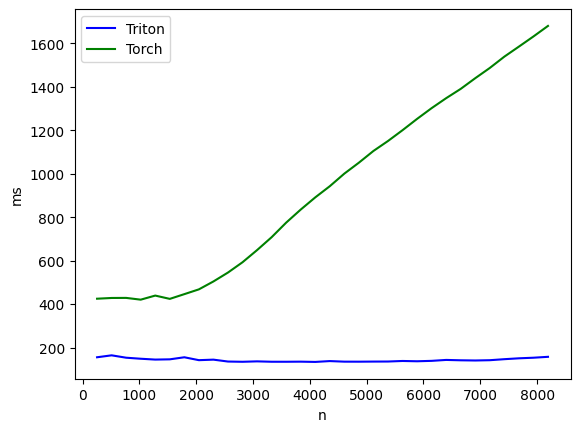

backward:
         n      Triton        Torch
0    256.0  155.452088   424.906820
1    512.0  164.380625   428.297430
2    768.0  153.422013   428.637147
3   1024.0  148.687676   420.509547
4   1280.0  144.826338   439.332187
5   1536.0  145.968542   424.126685
6   1792.0  155.446947   445.940822
7   2048.0  142.108157   467.928946
8   2304.0  144.519448   504.325271
9   2560.0  135.802388   545.305192
10  2816.0  134.706289   592.695832
11  3072.0  136.614457   648.597419
12  3328.0  134.865686   707.862437
13  3584.0  134.817615   774.899423
14  3840.0  135.272160   834.981143
15  4096.0  134.048700   891.112566
16  4352.0  137.908399   942.565739
17  4608.0  135.281101  1000.476837
18  4864.0  135.145724  1050.790668
19  5120.0  135.627002  1104.729414
20  5376.0  135.888219  1150.515437
21  5632.0  138.399646  1200.256467
22  5888.0  137.067795  1252.240658
23  6144.0  138.950348  1301.728368
24  6400.0  143.240705  1347.613692
25  6656.0  141.528919  1390.360117
26  6912.0  140.64

In [4]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[256 * i for i in range(1, 32+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':4, 'h':4, 'd':192, 'stride':16, 'kernel_size':32},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, provider, h, n, d, stride, kernel_size):
    device = 'cuda'
    dtype = torch.bfloat16
    x = torch.randn(b, n, h, d, device=device, dtype=dtype)
    x.requires_grad_(True)
    weight = torch.nn.Parameter(torch.randn(kernel_size, device=device, dtype=dtype))
    pe = torch.nn.Parameter(torch.randn(kernel_size, d, device=device, dtype=dtype))

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        y = torch_blcok_compress(x, weight, pe, stride)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[x, weight, pe])
    if provider == 'triton':
        y = triton_block_compress(x, weight, pe, stride)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[x, weight, pe])
    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)

## attention
- 对比三种实现方式

### 精度

In [10]:
n = 8192
kernel_size = 32
stride = 16
select_size = 64
# flex_attn必须要head_dim是2的指数倍
b, qh, kh, d, vd = 1, 64, 4, 128, 128
device = 'cuda'
dtype = torch.bfloat16
num_blocks = (n - kernel_size) // stride + 1
q1 = torch.randn(b, n, qh, d, device=device, dtype=dtype)
ck1 = torch.randn(b, num_blocks, kh, d, device=device, dtype=dtype)
cv1 = torch.randn(b, num_blocks, kh, vd, device=device, dtype=dtype)
q1.requires_grad_(True)
ck1.requires_grad_(True)
cv1.requires_grad_(True)
q2 = deepcopy(q1)
ck2 = deepcopy(ck1)
cv2 = deepcopy(cv1)
q3 = deepcopy(q1)
ck3 = deepcopy(ck1)
cv3 = deepcopy(cv1)

In [11]:
y1 = torch_cmp_attn(q1, ck1, cv1, kernel_size, stride)

y3, lse3 = triton_compress_attn(q3, ck3, cv3, kernel_size, stride)

# dy12不是连续的，dy3要求是连续的
dy12 = torch.randn_like(y1)
dy3 = torch.rand_like(y3)
dy3.data.copy_(dy12)

y1.backward(dy12)

y3.backward(dy3)

print('='*10 + ' triton vs torch')
print((y1-y3).abs().max().item(), '\t',(y1-y3).abs().mean().item())
print((q1.grad-q3.grad).abs().max().item(), '\t',(q1.grad-q3.grad).abs().mean().item())
print((ck1.grad-ck3.grad).abs().max().item(),'\t', (ck1.grad-ck3.grad).abs().mean().item())
print((cv1.grad-cv3.grad).abs().max().item(),'\t', (cv1.grad-cv3.grad).abs().mean().item())
# 由于是GQA，kv梯度进行bf16的累加，如果是fp32或者fp16会减少误差
if math.log2(d).is_integer():
    y2 = flex_cmp_attn(q2, ck2, cv2, kernel_size, stride)
    y2.backward(dy12)
    print('='*10 + ' triton vs flex')
    print((y2-y3).abs().max().item(), '\t',(y2-y3).abs().mean().item())
    print((q2.grad-q3.grad).abs().max().item(), '\t',(q2.grad-q3.grad).abs().mean().item())
    print((ck2.grad-ck3.grad).abs().max().item(), '\t',(ck2.grad-ck3.grad).abs().mean().item()) 
    print((cv2.grad-cv3.grad).abs().max().item(), '\t',(cv2.grad-cv3.grad).abs().mean().item())

========== triton vs torch
0.0234375 	 0.0004634857177734375
0.03125 	 0.00046539306640625
0.25 	 0.0074462890625
0.5 	 0.007415771484375
========== triton vs flex
0.01708984375 	 0.0003643035888671875
0.0390625 	 0.0004405975341796875
0.28125 	 0.006927490234375
0.25 	 0.006011962890625


### foward

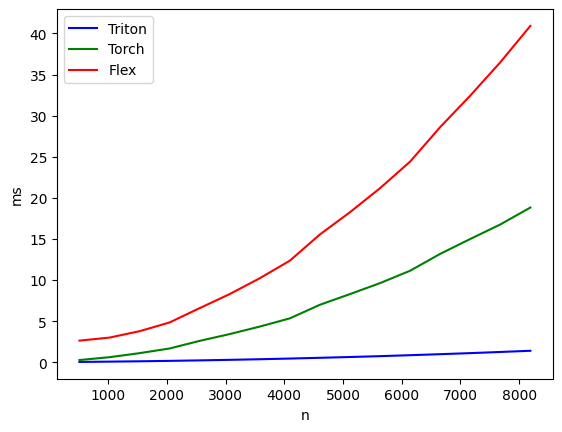

forward:
         n    Triton      Torch       Flex
0    512.0  0.040855   0.271489   2.628943
1   1024.0  0.075690   0.615518   3.001515
2   1536.0  0.117864   1.107517   3.778850
3   2048.0  0.168824   1.676527   4.842003
4   2560.0  0.228649   2.602432   6.586688
5   3072.0  0.294599   3.428690   8.295223
6   3584.0  0.367790   4.341237  10.223791
7   4096.0  0.450712   5.341776  12.360905
8   4608.0  0.542437   6.993858  15.547856
9   5120.0  0.638279   8.292225  18.255253
10  5632.0  0.742866   9.626791  21.176865
11  6144.0  0.858211  11.133429  24.411392
12  6656.0  0.981930  13.185651  28.604416
13  7168.0  1.111674  14.993318  32.430965
14  7680.0  1.251354  16.759502  36.487373
15  8192.0  1.396607  18.820948  40.913456


In [12]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[512 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch', 'flex'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
            "Flex",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':4, 'qh':64, 'kh':4, 'd':128, 'vd':128, 'stride':16, 'kernel_size':32},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, qh, kh, n, d, vd, stride, kernel_size, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    num_blocks = (n - kernel_size) // stride + 1
    q = torch.randn(b, n, qh, d, device=device, dtype=dtype)
    ck = torch.randn(b, num_blocks, kh, d, device=device, dtype=dtype)
    cv = torch.randn(b, num_blocks, kh, vd, device=device, dtype=dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch_cmp_attn(q, ck, cv, kernel_size, stride))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_compress_attn(q, ck, cv, kernel_size, stride))
    if provider == 'flex':
        if not math.log2(d).is_integer():
            return 10
        ms = triton.testing.do_bench(lambda: flex_cmp_attn(q, ck, cv, kernel_size, stride))
    return ms
benchmark.run(show_plots=True, print_data=True)

### backward

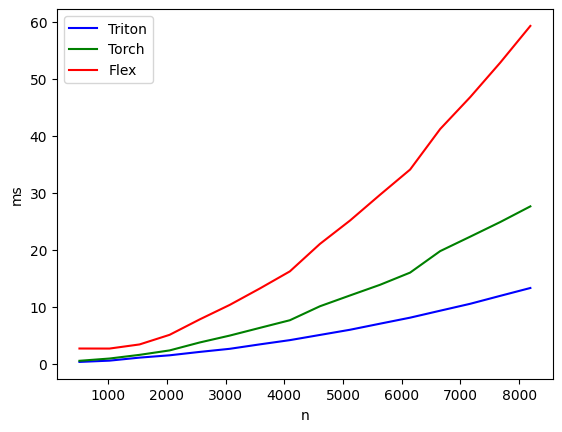

backward:
         n     Triton      Torch       Flex
0    512.0   0.281109   0.478387   2.636366
1   1024.0   0.505987   0.876888   2.628171
2   1536.0   1.037767   1.522942   3.353524
3   2048.0   1.444592   2.303661   5.042770
4   2560.0   2.039900   3.696950   7.748544
5   3072.0   2.584707   4.908699  10.298577
6   3584.0   3.364046   6.260839  13.177608
7   4096.0   4.108786   7.603432  16.187513
8   4608.0   5.019673  10.057334  21.008167
9   5120.0   5.930167  11.954964  25.110464
10  5632.0   6.998465  13.828970  29.640289
11  6144.0   8.054645  15.969979  34.071327
12  6656.0   9.278471  19.743767  41.188499
13  7168.0  10.493071  22.283745  46.797821
14  7680.0  11.888940  24.855936  52.858944
15  8192.0  13.266639  27.603668  59.296993


In [13]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[512 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch', 'flex'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
            "Flex",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':4, 'qh':64, 'kh':4, 'd':128, 'vd':128, 'stride':16, 'kernel_size':32},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, qh, kh, n, d,vd, stride, kernel_size, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    num_blocks = (n - kernel_size) // stride + 1
    q = torch.randn(b, n, qh, d, device=device, dtype=dtype)
    ck = torch.randn(b, num_blocks, kh, d, device=device, dtype=dtype)
    cv = torch.randn(b, num_blocks, kh, vd, device=device, dtype=dtype)
    q.requires_grad_(True)
    ck.requires_grad_(True)
    cv.requires_grad_(True)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        y = torch_cmp_attn(q, ck, cv, kernel_size, stride)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q, ck, cv])
    if provider == 'triton':
        y, _ = triton_compress_attn(q, ck, cv, kernel_size, stride)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q, ck, cv])
    if provider == 'flex':
        if not math.log2(d).is_integer():
            return 10
        y = flex_cmp_attn(q, ck, cv, kernel_size, stride)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q, ck, cv])
    return ms
benchmark.run(show_plots=True, print_data=True)

# Select_attn

In [1]:
import torch
import triton
import math
from copy import deepcopy
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
from torch_code import torch_select_for_fwd, torch_select_attn
from select_attn import select_for_fwd as triton_select_for_fwd
from select_attn import select_for_bwd
from select_attn import select_attn as triton_select_attn

## select

In [2]:
n = 8192
kernel_size = 32
stride = 16
select_size = 64
top_n = 16
# flex_attn必须要head_dim是2的指数倍
b, qh, kh, d, vd = 4, 64, 4, 128, 128
device = 'cuda'
dtype = torch.bfloat16
num_blocks = (n - kernel_size) // stride + 1
q = torch.randn(b, n, qh, d, device=device, dtype=dtype)
ck = torch.randn(b, num_blocks, kh, d, device=device, dtype=dtype)
lse = torch.rand(b, qh, n, device=device, dtype=torch.float32) + 10

In [3]:
p1, ind1 = torch_select_for_fwd(q, ck, lse, kernel_size, stride, select_size, top_n)
# select操作是不可导的，写前向就行了
p2, ind2 = triton_select_for_fwd(q, ck, lse, kernel_size, stride, select_size, top_n)
print((p1 - p2).abs().max(), (p1 - p2).abs().mean())

tensor(0.0004, device='cuda:0') tensor(1.5297e-06, device='cuda:0')


In [4]:
print(triton.testing.do_bench(lambda: torch_select_for_fwd(q, ck, lse, kernel_size, stride, select_size, top_n)))
print(triton.testing.do_bench(lambda: triton_select_for_fwd(q, ck, lse, kernel_size, stride, select_size, top_n)))

165.14317321777344
3.504584312438965


In [5]:
# 下面这两个不一定完全一样，p的小误差，可能选的就不一样, 大致差不多
# 128类似-100，表示不选，比如[0, 63]最多就选一个block
print(ind1[0, 0])
print(ind2[0, 0])

tensor([[  0, 128, 128,  ..., 128, 128, 128],
        [  0, 128, 128,  ..., 128, 128, 128],
        [  0, 128, 128,  ..., 128, 128, 128],
        ...,
        [127, 108, 100,  ...,  84,  55, 102],
        [127,  53,  47,  ...,  34,  64,  61],
        [127,  34,  30,  ...,   2,  28, 115]], device='cuda:0')
tensor([[  0, 128, 128,  ..., 128, 128, 128],
        [  0, 128, 128,  ..., 128, 128, 128],
        [  0, 128, 128,  ..., 128, 128, 128],
        ...,
        [127, 108, 100,  ...,  84,  55,  92],
        [127,  53,  47,  ...,  34,  64,  61],
        [127,  34,  30,  ...,  76,  28, 115]], device='cuda:0')


In [6]:
# 用于attention反向传播，bwd_ind表示kv block被哪个q选了，count表示个数
bwd_ind, counts = select_for_bwd(ind2)
print(bwd_ind[0, 0])
print(counts[0,0])

tensor([[   0,    1,    2,  ..., 8189, 8190, 8191],
        [  64,   65,   66,  ..., 8189, 8190, 8191],
        [ 128,  129,  130,  ..., 8188, 8189, 8190],
        ...,
        [8064, 8065, 8066,  ..., 8189, 8190, 8191],
        [8128, 8129, 8130,  ..., 8125, 8126, 8127],
        [   0,    1,    2,  ..., 8189, 8190, 8191]], device='cuda:0')
tensor([1861, 2490, 3578, 3055, 2593, 2720, 3240, 1814, 2708, 3632, 2351, 2366,
        1774, 1797, 2781, 2029, 2265, 1761, 1310, 2753, 1575, 1521, 1557, 1926,
         890, 1945, 1222, 1114, 2090, 1253, 2156, 1297, 1145, 1327, 1843, 1747,
        1139,  601, 1713, 1748, 1328,  749, 1294, 1503,  828, 1237,  555,  776,
         734,  960, 1198,  742, 1002,  677,  916, 1539,  805, 1046,  668,  525,
        1249,  500,  768,  449, 1122,  646,  328,  506,  719,  384,  524,  567,
         601, 1010,  649,  450,  467,  648,  526,  290,  703,  319,  641,  674,
         437,  329,  504,  454,  512,  310,  295,  289,  207,  271,  363,  474,
         409,  36

## attention

### 精度测试

In [4]:
n = 8192
kernel_size = 32
stride = 16
select_size = 64
top_n = 16
b, qh, kh, d, vd = 1, 64, 4, 192, 128
device = 'cuda'
dtype = torch.bfloat16
num_blocks = (n-kernel_size) // stride + 1
q1 = torch.randn(b, n, qh, d, device=device, dtype=dtype)
k1 = torch.randn(b, n, kh, d, device=device, dtype=dtype)
v1 = torch.randn(b, n, kh, vd, device=device, dtype=dtype)
q1.requires_grad_(True)
k1.requires_grad_(True)
v1.requires_grad_(True)
q2 = deepcopy(q1)
k2 = deepcopy(k1)
v2 = deepcopy(v1)
ck1 = torch.randn(b, num_blocks, kh, d, device=device, dtype=dtype)
lse = torch.rand(b, qh, n, device=device, dtype=torch.float32) + 10
_, ind = triton_select_for_fwd(q1, ck1, lse, kernel_size, stride, select_size, top_n)

In [5]:
y1 = torch_select_attn(q1, k1, v1, select_size, ind)
y2 = triton_select_attn(q2, k2, v2, select_size, ind)
dy1 = torch.randn_like(y1)
dy2 = torch.randn_like(y2)
dy2.data.copy_(dy1)
y1.backward(dy1)
y2.backward(dy2)
print('='*10 + ' triton vs torch')
print((y1-y2).abs().max().item(), (y1-y2).abs().mean().item())
print((q1.grad-q2.grad).abs().max().item(), (q1.grad-q2.grad).abs().mean().item())
print((k1.grad-k2.grad).abs().max().item(), (k1.grad-k2.grad).abs().mean().item())
print((v1.grad-v2.grad).abs().max().item(), (v1.grad-v2.grad).abs().mean().item())

========== triton vs torch
0.0234375 0.000240325927734375
0.015625 0.00020599365234375
0.046875 0.000782012939453125
0.0625 0.000904083251953125


### forward

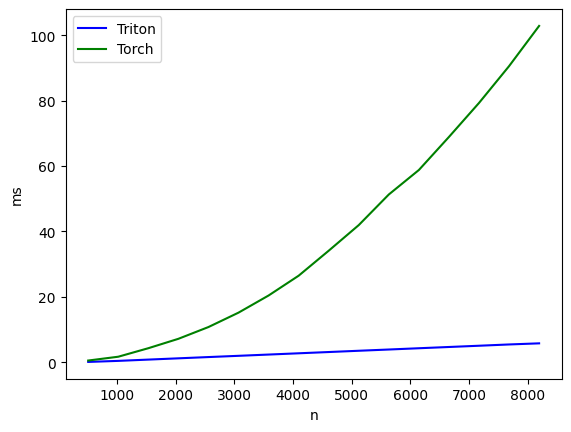

forward:
         n    Triton       Torch
0    512.0  0.134367    0.558260
1   1024.0  0.453910    1.723348
2   1536.0  0.844979    4.324294
3   2048.0  1.233460    7.196908
4   2560.0  1.619736   10.792074
5   3072.0  1.999725   15.191567
6   3584.0  2.385693   20.428303
7   4096.0  2.770959   26.476532
8   4608.0  3.155980   34.111969
9   5120.0  3.544270   41.943935
10  5632.0  3.926484   51.299198
11  6144.0  4.313921   58.780544
12  6656.0  4.697853   68.877922
13  7168.0  5.079704   79.269119
14  7680.0  5.470526   90.515778
15  8192.0  5.811203  102.812386


In [6]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[512 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':1, 'qh':64, 'kh':4, 'd':192, 'vd':128, 'stride':16, 'kernel_size':32, 'select_size': 64, 'top_n':16},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, qh, kh, n, d, vd, stride, kernel_size, select_size, top_n, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    device = 'cuda'
    dtype = torch.bfloat16
    num_blocks = (n-kernel_size) // stride + 1
    q = torch.randn(b, n, qh, d, device=device, dtype=dtype)
    k = torch.randn(b, n, kh, d, device=device, dtype=dtype)
    v = torch.randn(b, n, kh, vd, device=device, dtype=dtype)
    ck = torch.randn(b, num_blocks, kh, d, device=device, dtype=dtype)
    lse = torch.rand(b, qh, n, device=device, dtype=torch.float32) + 10
    _, ind = triton_select_for_fwd(q, ck, lse, kernel_size, stride, select_size, top_n)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch_select_attn(q, k, v, select_size, ind))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_select_attn(q, k, v, select_size, ind))
    return ms
benchmark.run(show_plots=True, print_data=True)

### backward

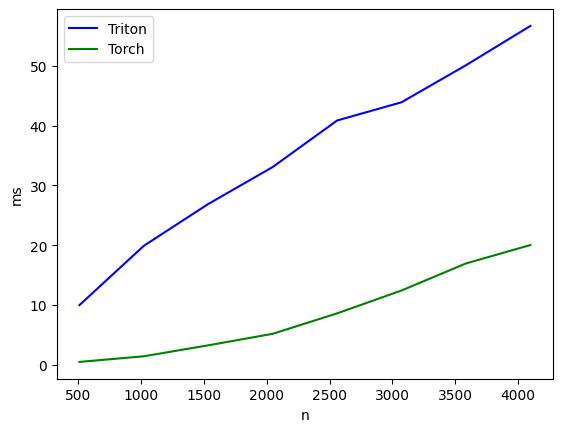

forward:
        n     Triton      Torch
0   512.0   9.985607   0.483335
1  1024.0  19.909721   1.428723
2  1536.0  26.902700   3.258766
3  2048.0  33.082527   5.186082
4  2560.0  40.865826   8.606391
5  3072.0  43.912590  12.430044
6  3584.0  50.108734  16.953287
7  4096.0  56.684418  20.031984


In [2]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[512 * i for i in range(1, 8+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'b':1, 'qh':64, 'kh':4, 'd':192, 'vd':128, 'stride':16, 'kernel_size':32, 'select_size': 64, 'top_n':16},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(b, qh, kh, n, d, vd, stride, kernel_size, select_size, top_n, provider):
    device = 'cuda'
    dtype = torch.bfloat16
    device = 'cuda'
    dtype = torch.bfloat16
    num_blocks = (n-kernel_size) // stride + 1
    q = torch.randn(b, n, qh, d, device=device, dtype=dtype)
    k = torch.randn(b, n, kh, d, device=device, dtype=dtype)
    v = torch.randn(b, n, kh, vd, device=device, dtype=dtype)
    q.requires_grad_(True)
    k.requires_grad_(True)
    v.requires_grad_(True)
    ck = torch.randn(b, num_blocks, kh, d, device=device, dtype=dtype)
    lse = torch.rand(b, qh, n, device=device, dtype=torch.float32) + 10
    _, ind = triton_select_for_fwd(q, ck, lse, kernel_size, stride, select_size, top_n)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        y = torch_select_attn(q, k, v, select_size, ind)
        dy = torch.rand_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q, k, v])
    if provider == 'triton':
        y = triton_select_attn(q, k, v, select_size, ind)
        dy = torch.rand_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[q, k, v])
    return ms
benchmark.run(show_plots=True, print_data=True)

# NSA_attn
- 效果还不是最好，目前知识demo

In [1]:
import torch
import triton
import triton.language as tl
import math
from copy import deepcopy
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
from nsa_attn import NsaAttention
from flash_attn import flash_attn_func as fa2
from flash_attn_interface import flash_attn_func as fa3

In [2]:
seed = 11
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)
device = 'cuda'
dtype = torch.bfloat16
n = 1024 * 32
kernel_size = 32
stride = 16
select_size = 64
window_size = 512
top_n = 16
b, qh, kh, d, vd = 1, 64, 4, 128, 128
q1 = torch.randn(b, n, qh, d, device=device, dtype=dtype)
k1 = torch.randn(b, n, kh, d, device=device, dtype=dtype)
v1 = torch.randn(b, n, kh, vd, device=device, dtype=dtype)
q1.requires_grad_(True)
k1.requires_grad_(True)
v1.requires_grad_(True)
q2 = deepcopy(q1)
k2 = deepcopy(k1)
v2 = deepcopy(v1)

nsa = NsaAttention(d, vd, kernel_size, stride, select_size, top_n, window_size).to(device).to(dtype)

In [3]:
print(triton.testing.do_bench(lambda: nsa(q1, k1, v1)))
print(triton.testing.do_bench(lambda: fa2(q2, k2, v2)))
print(triton.testing.do_bench(lambda: fa3(q2, k2, v2)))

38.47742462158203
97.133056640625
51.3298225402832


In [4]:
y1 = nsa(q1, k1, v1)
y2 = fa2(q2, k2, v2)
y3,_ = fa3(q2, k2, v2)
dy = torch.randn_like(y1)
print(triton.testing.do_bench(lambda: y1.backward(dy, retain_graph=True), grad_to_none=[q1, k1, v1]))
print(triton.testing.do_bench(lambda: y2.backward(dy, retain_graph=True), grad_to_none=[q2, k2, v2]))
print(triton.testing.do_bench(lambda: y3.backward(dy, retain_graph=True), grad_to_none=[q2, k2, v2]))

57.29888153076172
273.44354248046875
144.70413208007812
